In [ ]:
import jax.numpy as jnp
from jax import random, lax, nn, jit, vmap, value_and_grad, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import optax
from time import time

from quantum_error_correction_code import SurfaceCode
from neural_network import CNNDual, save_params

In [2]:
BATCH_SIZE = 16
TRAINING_BATCHES = 500_000

CODE_DISTANCE = 3

INIT_LEARNING_RATE = 1E-5
LEARNING_RATE = 1E-3
WARMUP_STEPS = 25_000
TRANSITION_STEP = 10_000
DECAY_RATE = 0.9

# Number of filters, Kernal size, Stride
NUM_FILTERS = int(2**jnp.ceil(jnp.log2(CODE_DISTANCE**2-1)))
CONV_LAYERS_INPUT_1 = [(NUM_FILTERS,2,1,0)]
CONV_LAYERS_INPUT_2 = [(NUM_FILTERS,1,1,0)]
CONV_LAYERS_STAGE_2 = [(NUM_FILTERS,2,1,1), (NUM_FILTERS,2,1,1)]
FC_LAYERS = [50, 2]
print(f"{NUM_FILTERS = }")

SEED = 69

# CODE_DEFORMATION = jnp.array([0,0,0,0,0,0,0,0,0])
# CODE_DEFORMATION = jnp.array([3,0,3,0,3,0,3,0,3])
CODE_DEFORMATION = jnp.array([2,0,2,3,2,3,2,0,2])
# CODE_DEFORMATION = jnp.array([2,3,2,0,2,0,2,3,2])
# CODE_DEFORMATION = jnp.array([2,2,2,2,2,2,2,2,2])

# px, pz = .01, .01
# ERROR_PROBS = jnp.array([px*(1-pz),px*pz,(1-px)*pz])
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])
# ERROR_PROBS = jnp.array([.01,.01,.01])

settings = {
    "CODE_DISTANCE": CODE_DISTANCE,
    "CODE_DEFORMATION": CODE_DEFORMATION,
    "ERROR_PROBS": ERROR_PROBS,
    "CONV_LAYERS_INPUT_1": CONV_LAYERS_INPUT_1,
    "CONV_LAYERS_INPUT_2": CONV_LAYERS_INPUT_2,
    "CONV_LAYERS_STAGE_2": CONV_LAYERS_STAGE_2,
    "FC_LAYERS": FC_LAYERS,
}

NUM_FILTERS = 8


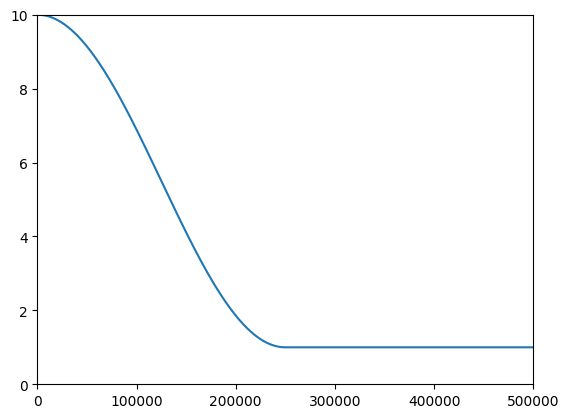

In [3]:
# p_init, p_target, p_decay_rate = 10, 1, 200_000

# scaling = lambda step: (p_init-p_target)*jnp.exp(-step/p_decay_rate) + p_target
scaling = optax.cosine_decay_schedule(
    init_value=10,
    decay_steps=TRAINING_BATCHES // 2,
    alpha=.1
)

x = jnp.linspace(0, TRAINING_BATCHES, 1_000)
y = scaling(x)

plt.figure()
plt.plot(x,y)
plt.ylim(0, 10)
plt.xlim(0, TRAINING_BATCHES)
plt.show()

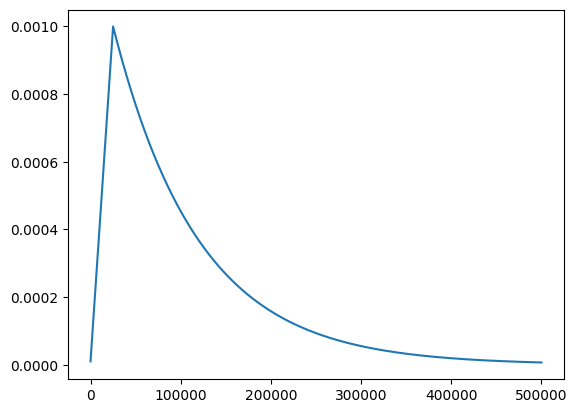

In [4]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.show()

optimizer = optax.adam(learning_rate)

In [5]:
def train(
    random_seed: int,
    code: SurfaceCode,
    parity_info: tuple[jnp.ndarray],
    probabilities: jnp.ndarray,
    prob_scaling_fun: callable,
    optimizer: optax.GradientTransformation,
    model: CNNDual
):
    @jit
    def loss_fn(
        model_params,
        x: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
        """
        return optax.sigmoid_binary_cross_entropy(
            logits=model.apply_batch(
                model_params, 
                x1=x, 
                x2=code.deformation_image(CODE_DEFORMATION)
            ),
            labels=y
        ).mean()

    @jit
    def update(
        model_params, 
        x: jnp.ndarray,
        y: jnp.ndarray,
        opt_state,
    ):
        mse_loss_batch_val_grad = value_and_grad(loss_fn, argnums=0)
        mse_loss_batch_val_grad = jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(model_params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        return loss, model_params, opt_state

    @jit
    def get_data(
        data_key,
        parity_info,
        step: int,
    ):
        data_key = random.split(data_key, num=BATCH_SIZE+1)
        errors = vmap(
            code.error,
            in_axes=(0, None),
            out_axes=0
        )(data_key[:-1], probabilities*prob_scaling_fun(step))
        imgs, logicals = vmap(
            code.syndrome_img,
            in_axes=(0, None),
            out_axes=0
        )(errors, parity_info)
        return imgs[:,None,:,:], logicals, data_key[-1]

    @jit
    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            parity_info,
            model_params,
            opt_state,
            data_key,
            losses,
        ) = val

        training_data, logicals, data_key = get_data(
            data_key,
            parity_info,
            step=i,
        )
        loss, model_params, opt_state = update(
            model_params,
            training_data,
            logicals,
            opt_state
        )
        losses = losses.at[i].set(loss)

        return (
            parity_info,
            model_params,
            opt_state,
            data_key,
            losses,
        )
    
    init_key, data_key = random.split(
        key = random.key(random_seed),
        num=2
    )

    model_params = model.init(init_key)
    optimizer_state = optimizer.init(model_params)

    losses = jnp.zeros(shape=TRAINING_BATCHES, dtype=jnp.float32)

    val_init = (
        parity_info,
        model_params,
        optimizer_state,
        data_key,
        losses,
    )

    vals = lax.fori_loop(0, TRAINING_BATCHES, _fori_body, val_init)

    return vals

In [ ]:
code = SurfaceCode(L=CODE_DISTANCE)
parity_info = code.deformation_parity_info(CODE_DEFORMATION)

model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
for name, layer_sizes in model.layer_sizes.items():
    print(name, layer_sizes)

t0 = time()

(
    parity_info,
    model_params,
    opt_state,
    data_key,
    losses,
) = train(
    random_seed=SEED,
    code=code,
    parity_info=parity_info,
    probabilities=ERROR_PROBS,
    prob_scaling_fun=scaling,
    optimizer=optimizer,
    model=model
)

print(losses[-1])

training_time = time() - t0
print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

CNN_input_1 [(1, 4, 4), (8, 3, 3)]
CNN_input_2 [(6, 3, 3), (8, 3, 3)]
CNN_stage_2 [(8, 3, 3), (8, 4, 4), (8, 5, 5)]
MLP_stage_3 [200, 50, 2]


In [7]:
from time import time

t0 = time()
# Training loop is not evaluated until one of its results are requsted
print(losses[-1])
training_time = time() - t0

print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

6.847079e-08


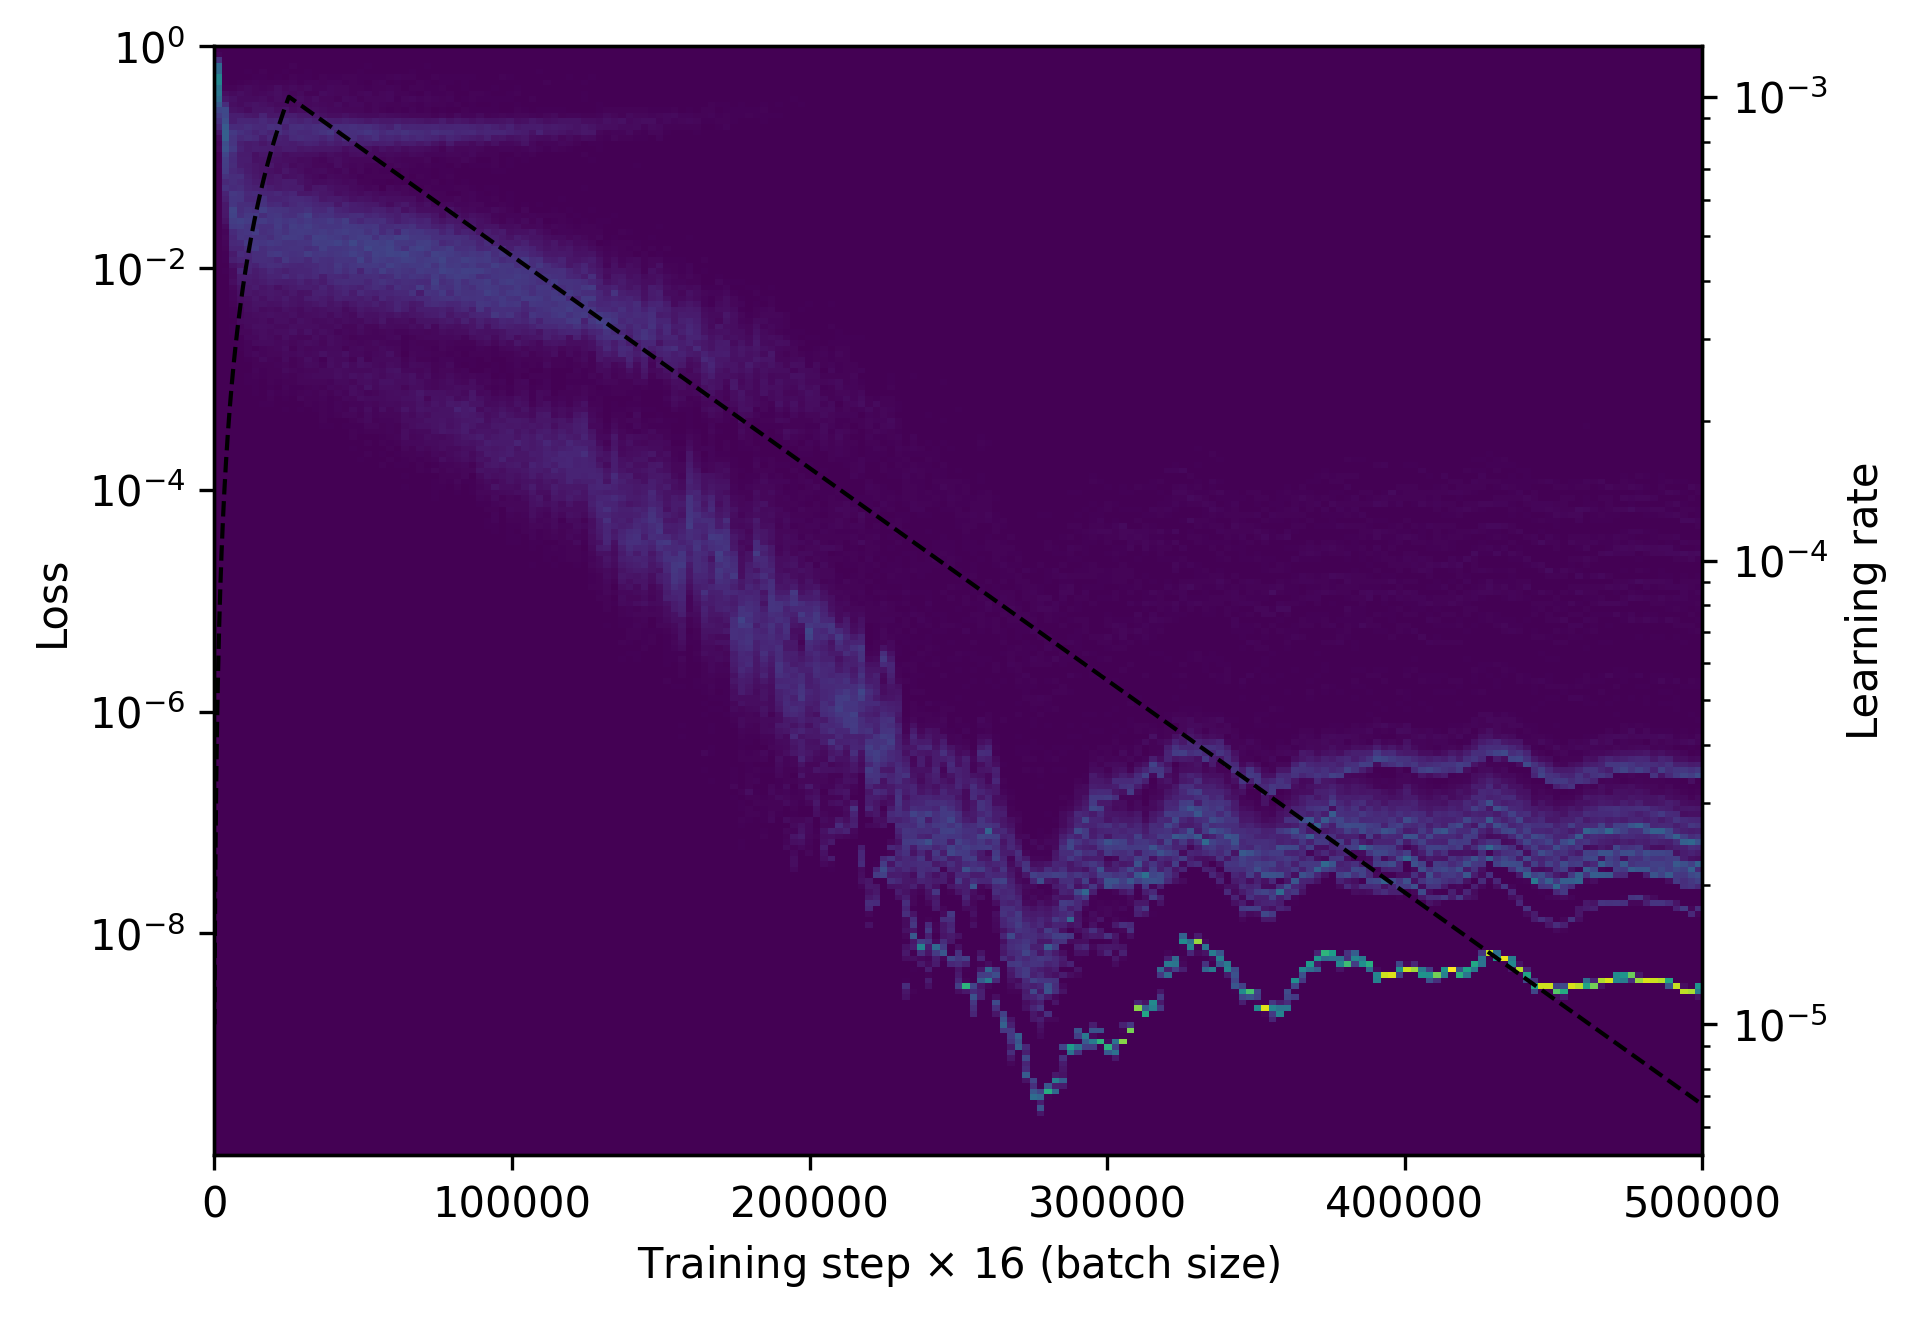

In [8]:
y_max = jnp.ceil(jnp.log10(losses).max()).astype(jnp.int32)
y_min = jnp.floor(jnp.log10(losses).min()).astype(jnp.int32)
step = jnp.arange(losses.shape[0])
plt.figure(dpi=300)
plt.hist2d(
    x=step, 
    y=losses, 
    bins=[
        jnp.linspace(0, losses.shape[0], 200),
        jnp.logspace(y_min, y_max, (y_max-y_min)*20+1)
    ],
    # norm=LogNorm(),
)
# plt.plot(step, losses, ',', alpha=.5)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel(f"Training step $\\times$ {BATCH_SIZE} (batch size)")

plt.twinx()
plt.plot(step, learning_rate(step), '--k', lw=1)
plt.yscale('log')
plt.ylabel("Learning rate")

plt.xlim(0, losses.shape[0])
plt.show()

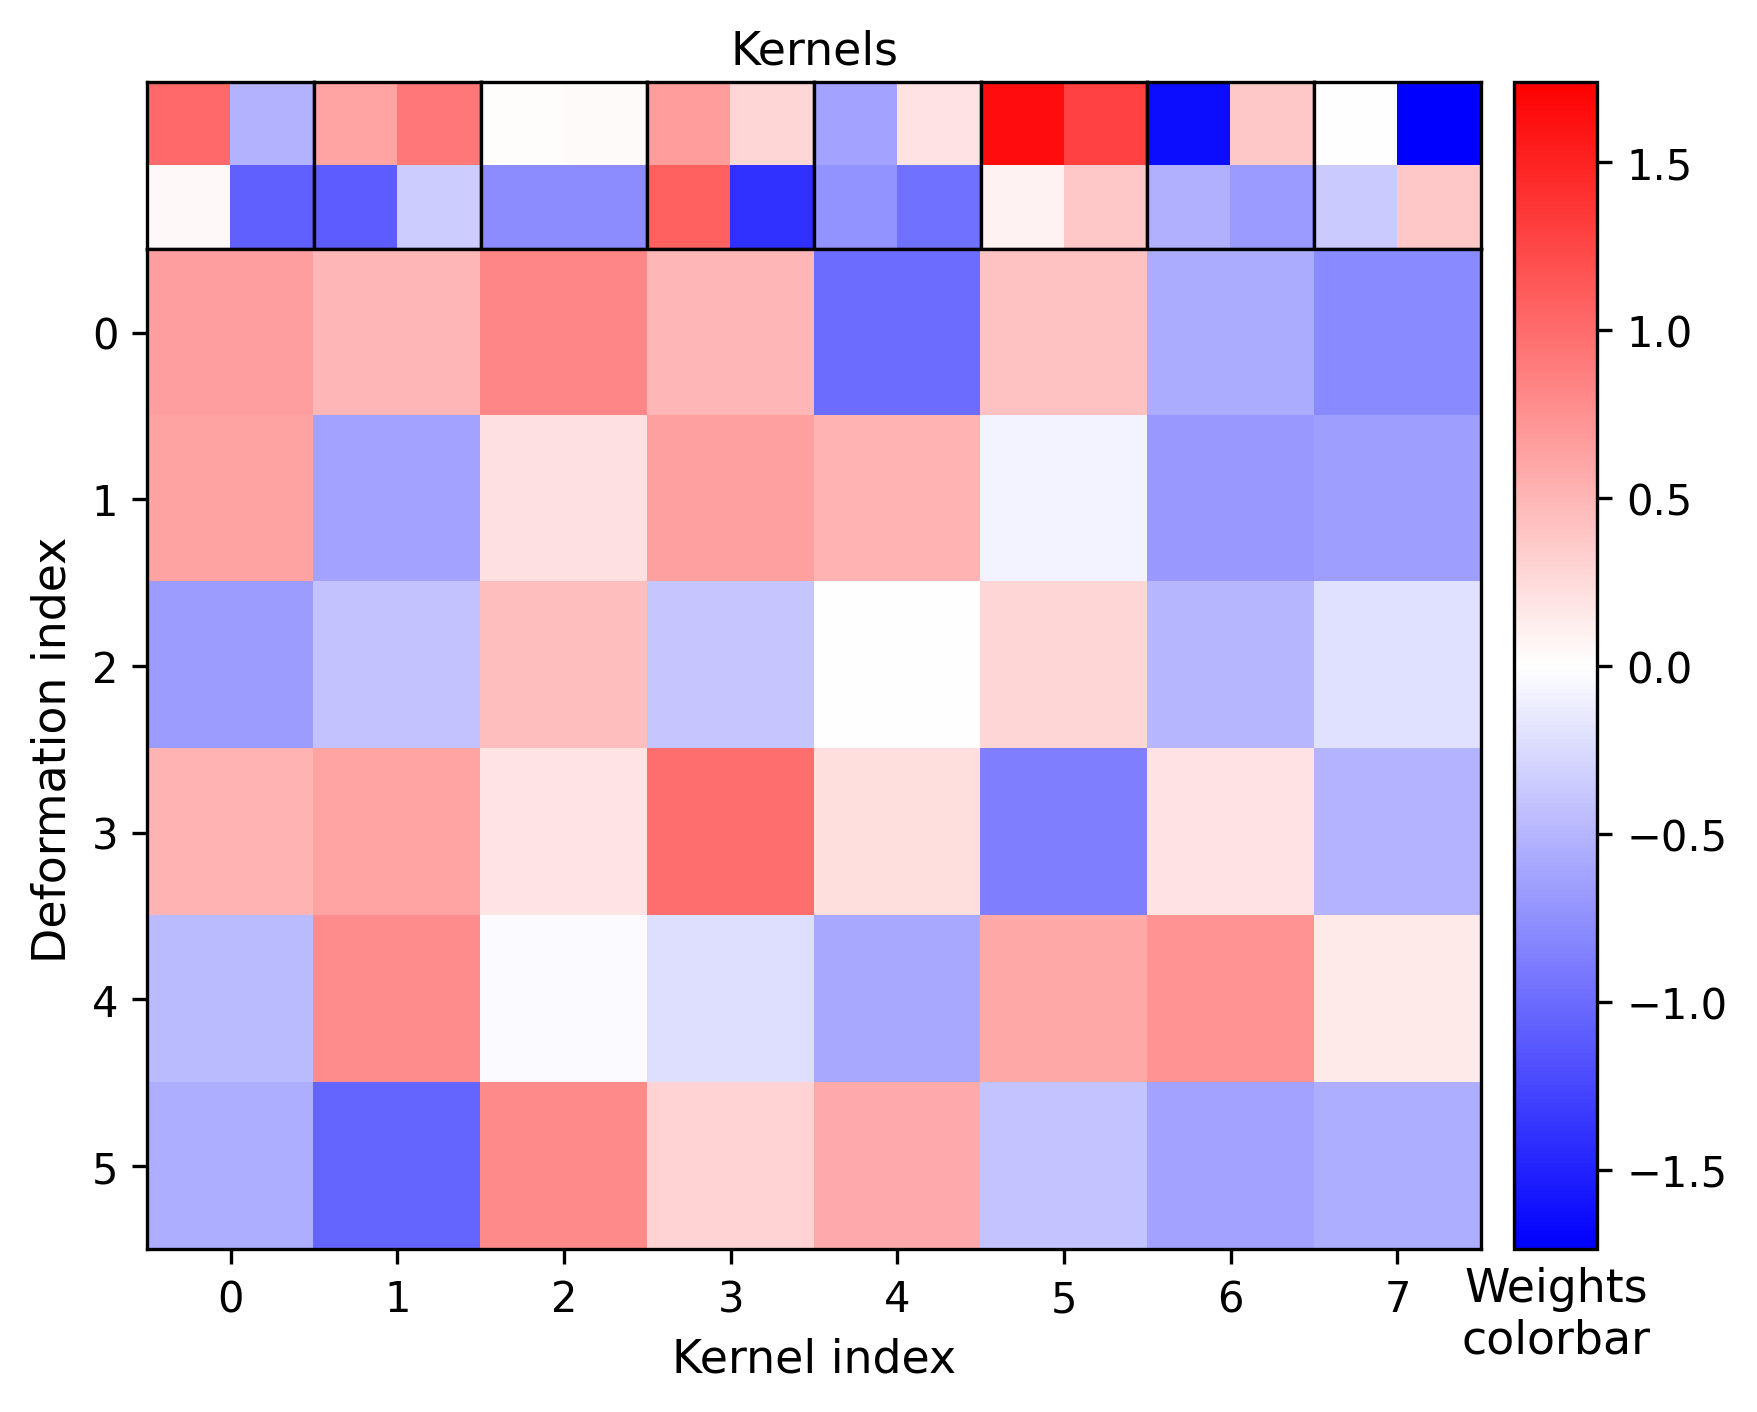

In [9]:
kernels = model_params['CNN_input_1'][0]['w']
mask = model_params['CNN_input_2'][0]['w'][:,:,0,0]
lims = jnp.abs(kernels).max()

fig_width = 5
fig = plt.figure(dpi=300, figsize=(
    fig_width / (kernels.shape[0]+1),
    fig_width / (kernels.shape[0]+1)
))
kernel_axs = [
    fig.add_axes((i,0,1,1))
    for i in range(kernels.shape[0])
]
mask_ax = fig.add_axes((0,-mask.shape[1],mask.shape[0],mask.shape[1]))
cax = fig.add_axes((mask.shape[0]+.2,-mask.shape[1],.5,mask.shape[1]+1))

for i, ax in enumerate(kernel_axs):
    im = ax.imshow(kernels[i,0], vmin=-lims, vmax=lims, cmap="bwr")
    # ax.set_title(f"{i}")
    ax.set_xticks([])
    ax.set_yticks([])
im = mask_ax.imshow(mask.T, vmin=-lims, vmax=lims, cmap="bwr")
mask_ax.set_xlabel("Kernel index", fontsize=11)
mask_ax.set_ylabel("Deformation index", fontsize=11)
mask_ax.set_title("Kernels", y=1.16, fontsize=11)
fig.colorbar(im, cax=cax)
cax.set_xlabel("Weights\ncolorbar", fontsize=11)

plt.savefig("figs/neural_network_decoder_weights_map.eps", bbox_inches='tight')
plt.savefig("figs/neural_network_decoder_weights_map.png", bbox_inches='tight')
plt.show()

In [10]:
save_params(model_params, settings, f"data/{''.join(str(v) for v in CODE_DEFORMATION)}_distance{CODE_DISTANCE}_decoder.json")

# Compare to other decoders

In [11]:
data_key = random.key(42)

In [12]:
def get_data(
    data_key,
    batch_size: int,
    parity_info: tuple[jnp.ndarray],
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(data_key[:-1], ERROR_PROBS)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    print(errors.shape)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    recovery: jnp.ndarray,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

In [13]:
parity_info = code.deformation_parity_info(CODE_DEFORMATION)
imgs, syndromes, logicals, data_key = get_data(
    data_key, 
    batch_size=1_000_000, 
    parity_info=parity_info
)

(1000000, 2, 9)


NN-model decoder

In [14]:
nn_logicals = (nn.sigmoid(
    model.apply_batch(model_params, imgs, code.deformation_image(CODE_DEFORMATION))
) > .5).astype(jnp.int32)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * nn_logicals[:, 0] + nn_logicals[:, 1]
nn_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

MWPM decoder

In [15]:
from pymatching import Matching

def deform_recovery_batch(
    recovery = jnp.ndarray,
):
    def _deform_recovery(
        recovery = jnp.ndarray,
    ):
        inv_transformations = jnp.array([
            [[1, 0], [0, 1]],  # I
            [[1, 1], [0, 1]],  # X-Y
            [[1, 0], [1, 1]],  # Y-Z
            [[0, 1], [1, 0]],  # X-Z
            [[1, 1], [1, 0]],  # X-Z-Y
            [[0, 1], [1, 1]],  # X-Y-Z
        ])

        recovery_deformed = vmap(
            lambda A, B, Di: jnp.dot(Di, jnp.stack([A, B])) % 2,
            in_axes=(0, 0, 0),
            out_axes=1
        )(
            recovery[0],
            recovery[1],
            inv_transformations[CODE_DEFORMATION]
        )

        return recovery_deformed
    
    return vmap(_deform_recovery)(recovery)

# Decodes the un-deformed surface code and then deforms the recovery operation
matcher = Matching(
    jnp.append(code.hx_original, code.hz_original, axis=1)
)
recovery = matcher.decode_batch(syndromes)
recovery = recovery.reshape((recovery.shape[0], 2, recovery.shape[1]//2))
recovery = deform_recovery_batch(recovery)
mwpm_logicals = logicals_of_recovery(recovery, parity_info)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * mwpm_logicals[:, 0] + mwpm_logicals[:, 1]
mwpm_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

Perfect maximum likelihood decoder

In [16]:
if code.num_data_qubits > 10:
    pml_hist = jnp.zeros((4,4), dtype=jnp.int32)
else:
    from perfect_maximum_likelihood_decoder import PMLD

    perfect_decoder = PMLD(code, ERROR_PROBS, parity_info)
    pml_logicals = perfect_decoder.decode_batch(syndromes)

    i = 2 * logicals[:, 0] + logicals[:, 1]
    j = 2 * pml_logicals[:, 0] + pml_logicals[:, 1]
    pml_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

### Compare

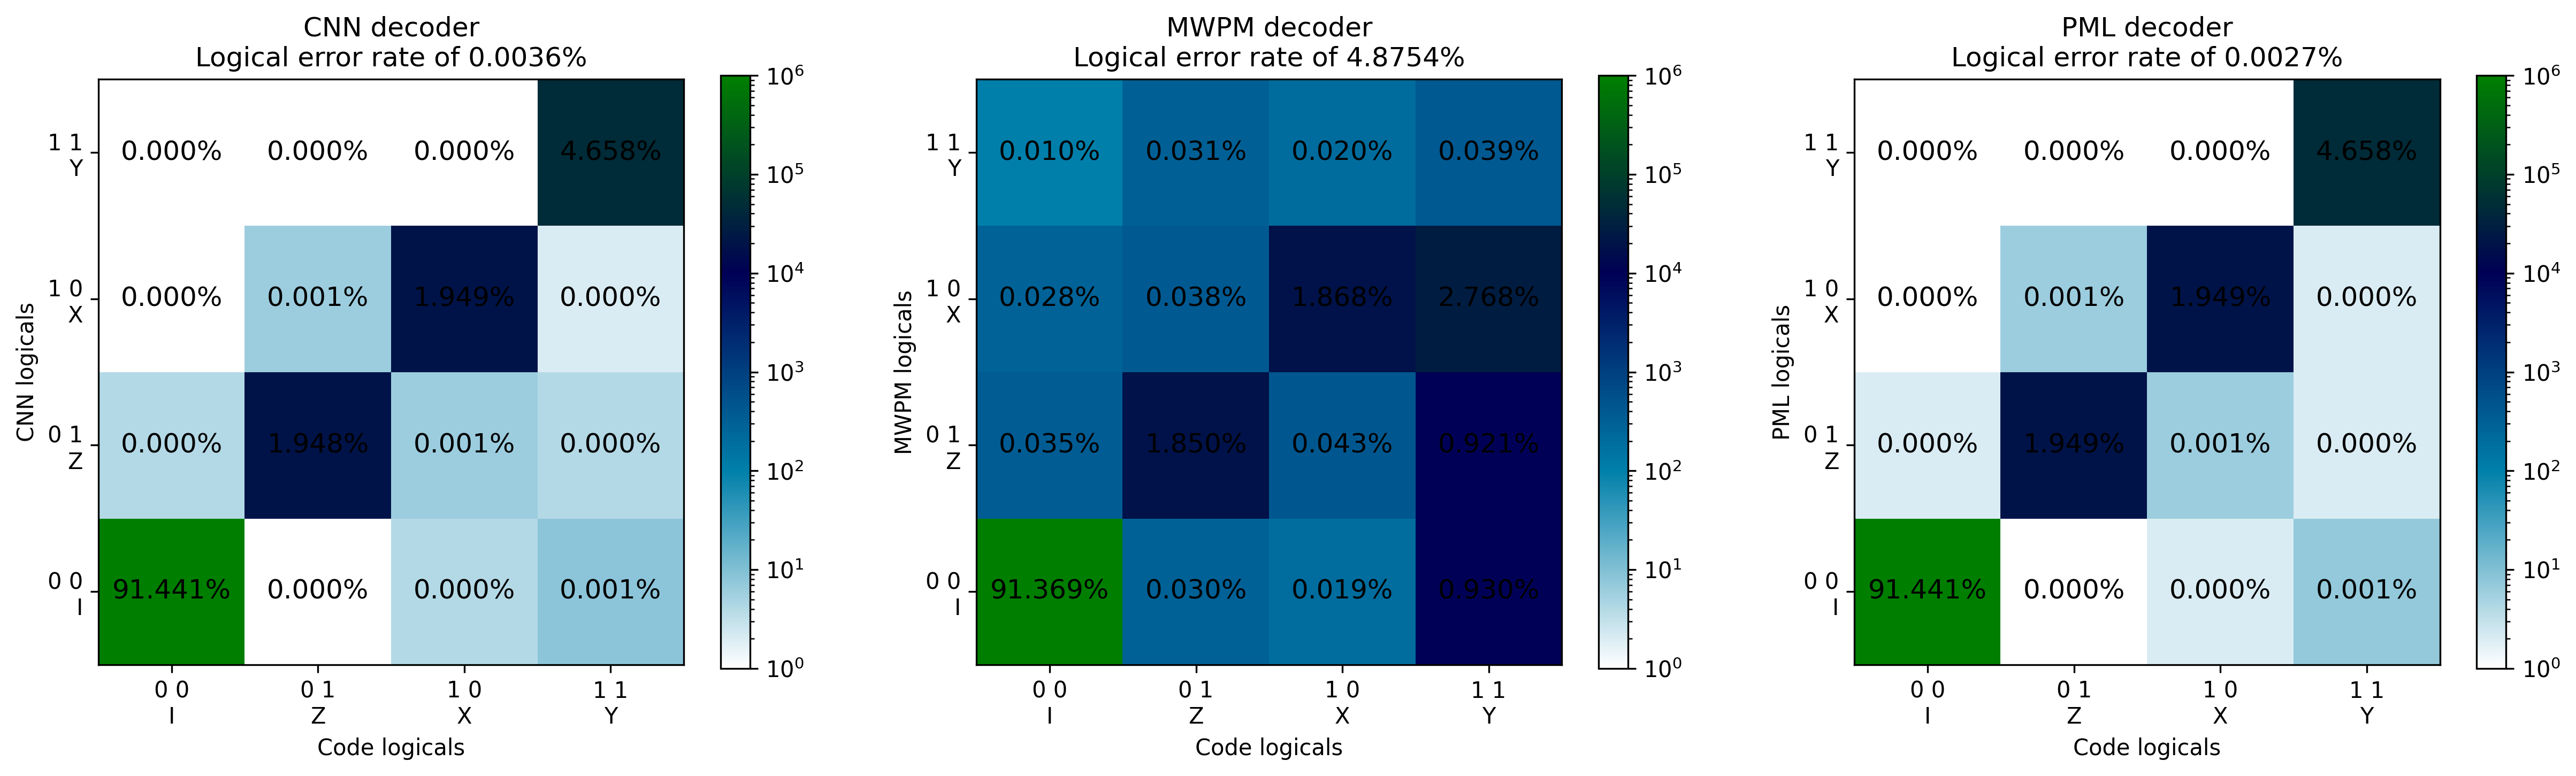

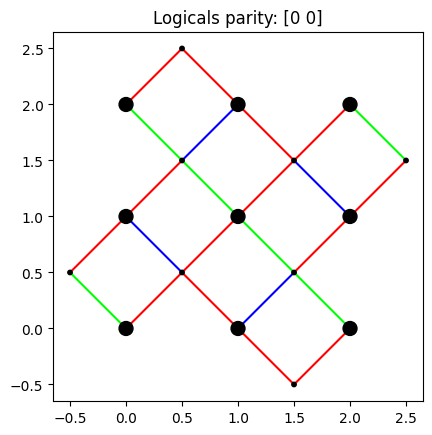

In [17]:

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plot: tuple[plt.Figure, list[plt.Axes]] = plt.subplots(ncols=3)
fig, axs = plot
fig.set_figwidth(20)
fig.set_dpi(300)
for ax, hist, name in zip(
    axs,
    [nn_hist, mwpm_hist, pml_hist],
    ["CNN", "MWPM", "PML"]
):
    img = ax.imshow(
        hist, 
        origin='lower', 
        cmap='ocean_r',
        # cmap='plasma_r',
        # vmin=0,
        # vmax=hist.sum(),
        norm=LogNorm(vmin=1, vmax=1E6)
    )
    fig.colorbar(img)
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_xlabel('Code logicals')
    ax.set_ylabel(f'{name} logicals')
    for x, row in enumerate(jnp.array(hist).T):
        for y, count in enumerate(row):
            ax.text(x, y, f'{count/hist.sum():.3%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
    ax.set_title(f'{name} decoder\nLogical error rate of {1 - hist.diagonal().sum() / hist.sum():.4%}')
plt.show()

code.show(parity_info)